# Temperature change across the Earth

This project involves the analysis of a climate projection of temperature change across the Earth under a 'middle-of-the-road' future scenario in which global mean temperatures reach more than 2 degress centigrade above the pre-industrial.

We will be using data created by the NorESM2 climate model and processed and as part of the ClimateBench [dataset](https://zenodo.org/records/7064308), described in this [paper](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021MS002954). 

In [1]:
# importing the libraries
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import math

## 1. Read in historical and future (estimated) CO2 emissions data

Monthly CO2 emissions data is available since 1850 globally for each industrial sector. We want to use annual average totals of the emissions for all sectors for our analysis. Since CO2 has a very long lifetime in the atmosphere (1000's of years), we can assume that the total amount of anthropogenic CO2 in the atmosphere is the cumulative sum of all emissions since 1850. This is what we will use for our analysis.

In [2]:
# Path to read the input files from
input_path = 'public/'

### 1a. Create interpolated cumalitve CO2 from the raw data using Pandas

In [3]:
# These input files provide CO2 emissions data for the historical period (1850-2014) and the future period (2015-2100). They should all be concatenated into a single file.

historical_input_files = ['CO2_emissions/CO2-em-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_200001-201412.csv',
                          'CO2_emissions/CO2-em-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_195001-199912.csv',
                          'CO2_emissions/CO2-em-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_190001-194912.csv',
                          'CO2_emissions/CO2-em-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_185101-189912.csv']

future_input_file = 'CO2_emissions/CO2-em-anthro_input4MIPs_emissions_ScenarioMIP_IAMC-MESSAGE-GLOBIOM-ssp245-1-1_gn_201501-210012.csv'

First we will need to read, concatenate and process the raw CSV files, and sum over the `sector` and `month` columns to get an annual total.

In [4]:
# Read the input files
df_list = []
df_concat = pd.DataFrame()

# Adding the dataframes in a single list
for file in historical_input_files:
    df = pd.read_csv(file)
    df_list.append(df)

# Concatenating the individual dataframes into a single dataframe
df_concat = pd.concat(df_list, ignore_index=True)

#Sorting the combined dataframe according to year, sector and month
df_concat.sort_values(['year', 'sector', 'month'], inplace=True)

#Dropping the old indexes before sorting and resetting it with new ones
df_concat.reset_index(drop=True, inplace=True)

#print the processed combined dataframe
df_concat

,year,em,sector,month,global_total,units
0,1851,CO2,AGR,1,0.000000,kt
1,1851,CO2,AGR,2,0.000000,kt
2,1851,CO2,AGR,3,0.000000,kt
3,1851,CO2,AGR,4,0.000000,kt
4,1851,CO2,AGR,5,0.000000,kt
...,...,...,...,...,...,...
15739,2014,CO2,WST,8,10945.019085,kt
15740,2014,CO2,WST,9,10591.953954,kt
15741,2014,CO2,WST,10,10945.019085,kt
15742,2014,CO2,WST,11,10591.953954,kt


In [5]:
# Adding the data for one year over different sector and months
# so that we get one total CO2 value for a year
df_concat['cumulative_CO2'] = df_concat.groupby(['year'])['global_total'].transform('cumsum')
result_df = df_concat.groupby('year').tail(1)[['year', 'cumulative_CO2']].reset_index(drop=True)
result_df

,year,cumulative_CO2
0,1851,1.889473e+05
1,1852,1.965696e+05
2,1853,2.050344e+05
3,1854,2.414711e+05
4,1855,2.439077e+05
...,...,...
159,2010,3.218227e+07
160,2011,3.318972e+07
161,2012,3.366014e+07
162,2013,3.465121e+07


**Note**, the future data is only provided every five years so that will need linearly intepolated to get annual values.

In [6]:
# Readin the future data
future_data = pd.read_csv(future_input_file)

# Adding the data over different sector and month for a year to get a single CO2 value for a year
future_data['cumulative_CO2'] = future_data.groupby(['year'])['global_total'].transform('cumsum')
result_future_df = future_data.groupby('year').tail(1)[['year', 'cumulative_CO2']].reset_index(drop=True)
result_future_df

# To get the values for the intermediate years we will create a new df with all the future years from 2015 to 2100
min_year = result_future_df['year'].min()
max_year = result_future_df['year'].max()
all_years = list(range(min_year, max_year + 1))
all_years_df = pd.DataFrame({'year': all_years})

# Merging the all_years_df with the result_future_df and interpolating to get the missing values
final_df = pd.merge(all_years_df, result_future_df, on='year', how='left')
final_df['cumulative_CO2'] = final_df['cumulative_CO2'].interpolate()

final_df

,year,cumulative_CO2
0,2015,3.487068e+07
1,2016,3.519111e+07
2,2017,3.551154e+07
3,2018,3.583197e+07
4,2019,3.615240e+07
...,...,...
81,2096,1.493869e+07
82,2097,1.434807e+07
83,2098,1.375745e+07
84,2099,1.316683e+07


In [7]:
# Concatanating the past and future dataframes to get the overall data for all the years
result = pd.concat([result_df, final_df], ignore_index=True)
result

,year,cumulative_CO2
0,1851,1.889473e+05
1,1852,1.965696e+05
2,1853,2.050344e+05
3,1854,2.414711e+05
4,1855,2.439077e+05
...,...,...
245,2096,1.493869e+07
246,2097,1.434807e+07
247,2098,1.375745e+07
248,2099,1.316683e+07


Now, divide by 1e6 to get the units in GtC (Giga tonnes of carbon) and calculate the cumulative sum.

In [8]:
# Dividing by 1e6 to change the unit to GtC
result['cumulative_CO2'] = result['cumulative_CO2']/math.pow(10,6)

#Taking cumulative sum over the years
result['cumulative_CO2'] = result['cumulative_CO2'].cumsum()
result

,year,cumulative_CO2
0,1851,0.188947
1,1852,0.385517
2,1853,0.590551
3,1854,0.832022
4,1855,1.075930
...,...,...
245,2096,4302.526561
246,2097,4316.874630
247,2098,4330.632079
248,2099,4343.798907


## 2. Read in the temperature data

Note, this temperature change as modelled by the NorESM2 climate model relative to the pre-industrial period. It's purely driven by the prescribed emissions, so it won't perfect represent the actual temperatures we experienced in a given year (which are subject to chaotic fluctuations), but it's a good model.

In [10]:
temperture_input_file = 'global_temparature.nc'

# Read the input files
temparature_dataset = xr.open_dataset(temperture_input_file,decode_times=True)
temparature_dataset

<xarray.Dataset>
Dimensions:   (time: 250, lat: 96, lon: 144)
Coordinates:
  * time      (time) int64 1851 1852 1853 1854 1855 ... 2096 2097 2098 2099 2100
  * lat       (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon       (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
    quantile  float64 ...
Data variables:
    tas       (time, lat, lon) float32 ...

And take the global mean. Don't forget to calculate and include weights for the latitude of each grid cell.

In [11]:
# The earth is not completely circular so we will calculate the cosine of the latitude after converting it into radians
latitude_cosine = np.cos(np.deg2rad(temparature_dataset['lat']))

# For each latitude we will calculating the weights 
weights = latitude_cosine / latitude_cosine.sum(dim='lat')
weights

<xarray.DataArray 'lat' (lat: 96)>
array([1.01255054e-18, 5.46742659e-04, 1.09288746e-03, 1.63783721e-03,
       2.18099601e-03, 2.72176992e-03, 3.25956761e-03, 3.79380102e-03,
       4.32388595e-03, 4.84924279e-03, 5.36929705e-03, 5.88348006e-03,
       6.39122957e-03, 6.89199036e-03, 7.38521487e-03, 7.87036375e-03,
       8.34690650e-03, 8.81432204e-03, 9.27209924e-03, 9.71973754e-03,
       1.01567474e-02, 1.05826511e-02, 1.09969828e-02, 1.13992894e-02,
       1.17891311e-02, 1.21660815e-02, 1.25297286e-02, 1.28796745e-02,
       1.32155367e-02, 1.35369479e-02, 1.38435567e-02, 1.41350277e-02,
       1.44110423e-02, 1.46712986e-02, 1.49155121e-02, 1.51434156e-02,
       1.53547601e-02, 1.55493144e-02, 1.57268657e-02, 1.58872199e-02,
       1.60302017e-02, 1.61556547e-02, 1.62634417e-02, 1.63534449e-02,
       1.64255658e-02, 1.64797257e-02, 1.65158651e-02, 1.65339448e-02,
       1.65339448e-02, 1.65158651e-02, 1.64797257e-02, 1.64255658e-02,
       1.63534449e-02, 1.62634417e-02, 1.61556547e-02, 1.60302017e-02,
       1.58872199e-02, 1.57268657e-02, 1.55493144e-02, 1.53547601e-02,
       1.51434156e-02, 1.49155121e-02, 1.46712986e-02, 1.44110423e-02,
       1.41350277e-02, 1.38435567e-02, 1.35369479e-02, 1.32155367e-02,
       1.28796745e-02, 1.25297286e-02, 1.21660815e-02, 1.17891311e-02,
       1.13992894e-02, 1.09969828e-02, 1.05826511e-02, 1.01567474e-02,
       9.71973754e-03, 9.27209924e-03, 8.81432204e-03, 8.34690650e-03,
       7.87036375e-03, 7.38521487e-03, 6.89199036e-03, 6.39122957e-03,
       5.88348006e-03, 5.36929705e-03, 4.84924279e-03, 4.32388595e-03,
       3.79380102e-03, 3.25956761e-03, 2.72176992e-03, 2.18099601e-03,
       1.63783721e-03, 1.09288746e-03, 5.46742659e-04, 1.01255054e-18])
Coordinates:
  * lat       (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
    quantile  float64 0.9

In [12]:
# calculating the weighted avergae of the temperature using the weights generated in the previous step
temperature_weighted = temparature_dataset['tas'].weighted(weights)

# Taking the mean of the weighted temperature along the latitude and the longitude
weighted_mean = temperature_weighted.mean(("lon", "lat"))
weighted_mean

<xarray.DataArray 'tas' (time: 250)>
array([ 6.72612374e-02,  1.20035238e-01,  1.92815950e-01,  1.95746039e-01,
        8.08993653e-02,  1.72920985e-01,  2.25773570e-01,  1.69944321e-01,
        6.61424517e-02,  5.21966283e-02,  3.33512396e-02,  7.67547077e-02,
        1.19199507e-01,  2.22590415e-01,  7.06020892e-02, -3.75847833e-04,
        3.97141062e-02,  3.24739600e-01,  2.71118462e-01,  9.36015088e-02,
        5.82252315e-02,  9.86642965e-02,  1.13780169e-01,  6.34739321e-02,
        1.47293307e-01,  1.97818004e-01,  2.85449916e-01,  2.01916945e-01,
        6.62375962e-02,  7.17937239e-02,  1.16519847e-01,  1.18019980e-01,
        1.85678850e-01, -1.52653921e-01,  2.00849461e-02,  6.03316979e-02,
        3.63532523e-02, -6.34130996e-02, -3.71111798e-02,  1.73577156e-01,
        4.02010862e-02, -2.47804956e-02, -1.10920204e-02,  1.49081092e-01,
        1.71308035e-01,  1.04495198e-01,  1.67197942e-01,  1.59396502e-01,
        1.59392914e-01,  1.61038228e-01,  1.31962074e-01,  5.44117564e-03,
       -5.49537461e-02,  4.08114067e-02,  3.14748688e-02,  1.01366049e-01,
        1.83650116e-02,  7.37897515e-02,  2.18975589e-01,  5.29528008e-02,
       -5.51062532e-03, -3.91623960e-02, -1.71177998e-02, -1.17959140e-01,
        3.20987506e-02,  5.74513159e-02, -1.84329588e-02,  9.96872244e-02,
        2.49975685e-01,  2.94183267e-01,  1.95579886e-01,  2.82491804e-01,
        3.19973584e-01,  2.84841497e-01,  3.06335213e-01,  1.99241003e-01,
        3.01548520e-01,  3.49974037e-01,  2.94750302e-01,  2.78432015e-01,
...
        9.00831240e-01,  8.45252087e-01,  9.02879005e-01,  9.36569244e-01,
        9.60462383e-01,  1.07070667e+00,  1.11076983e+00,  1.03452646e+00,
        1.01761192e+00,  1.14364759e+00,  1.07994920e+00,  1.11884070e+00,
        1.18613664e+00,  1.16338594e+00,  1.29047341e+00,  1.42639843e+00,
        1.30764482e+00,  1.23807414e+00,  1.13020370e+00,  1.29443518e+00,
        1.54668998e+00,  1.50085058e+00,  1.34577803e+00,  1.33297494e+00,
        1.40430999e+00,  1.40757833e+00,  1.42872005e+00,  1.40285110e+00,
        1.54269582e+00,  1.66138098e+00,  1.56378022e+00,  1.39987839e+00,
        1.39758879e+00,  1.48157894e+00,  1.66829836e+00,  1.60636213e+00,
        1.62231252e+00,  1.71460917e+00,  1.65752638e+00,  1.64908420e+00,
        1.71204971e+00,  1.76603396e+00,  1.71172225e+00,  1.80854068e+00,
        1.95412314e+00,  1.87063017e+00,  1.83833707e+00,  1.76695209e+00,
        1.80987820e+00,  1.89355241e+00,  1.92653268e+00,  1.97297582e+00,
        1.98228104e+00,  1.91828613e+00,  1.79187373e+00,  1.86555629e+00,
        1.81606824e+00,  1.78737220e+00,  2.03393064e+00,  2.09874396e+00,
        1.90060659e+00,  1.94876167e+00,  2.14332166e+00,  2.12103312e+00,
        2.04069285e+00,  2.02418831e+00,  2.07208779e+00,  2.19144215e+00,
        2.23078161e+00,  2.04971392e+00,  2.07181918e+00,  2.12204225e+00,
        2.11252537e+00,  2.00896052e+00,  2.02257726e+00,  2.18747148e+00,
        2.14751340e+00,  2.16579821e+00])
Coordinates:
  * time      (time) int64 1851 1852 1853 1854 1855 ... 2096 2097 2098 2099 2100
    quantile  float64 0.9

## 3. Simple regression model of global warming

Global warming can be surprisingly well predicted just using a linear model of cumulative CO2 emissions. This is because the CO2 emissions are the primary driver of global warming, and the CO2 stays in the atmosphere for a long time (see e.g. https://www.nature.com/articles/ngeo3031).

To get global temperature as a function of cumaltive CO2. We can use the `LinearRegression` class from `sklearn.linear_model`, with documentation provided [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

Since we're only aiming to create an interpolation model, we don't need to worry too much about keeping a test set aside. We can just use all the data to train the model.

In [13]:
from sklearn.linear_model import LinearRegression

# To get global temperature as a function of cumaltive CO2, taking X and y accordingly
X = np.array(result['cumulative_CO2']).reshape(-1,1)
y =  weighted_mean
linear_reg_model = LinearRegression()

#Fitting the model
linear_reg_model.fit(X, y)
# predicting the temperature using the model built in previous step
predicted_temperatures = linear_reg_model.predict(X)


Plot gobal mean temperature as a function of cumalative CO2 emissions, along with the regression fit


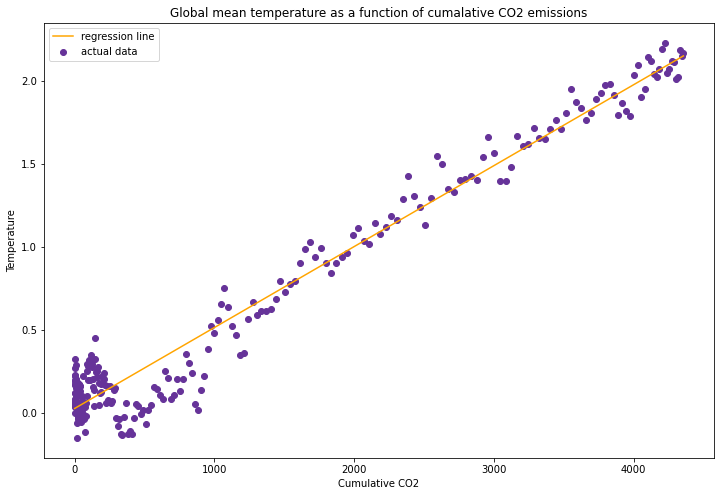

In [14]:
#Plotting the cumulative_co2 and original temperature as scatter plot
plt.figure(figsize=(12,8))
plt.scatter(X,y, label='actual data', color='rebeccapurple')
# Plotting the regression line using the cumulative CO2 and predicted temperature
plt.plot(X,predicted_temperatures, color='orange', label='regression line')
plt.xlabel('Cumulative CO2')
plt.ylabel('Temperature')
plt.legend()
plt.title('Global mean temperature as a function of cumalative CO2 emissions')
plt.show()

Plot gobal mean temperature as a function of year, along with the regression fit

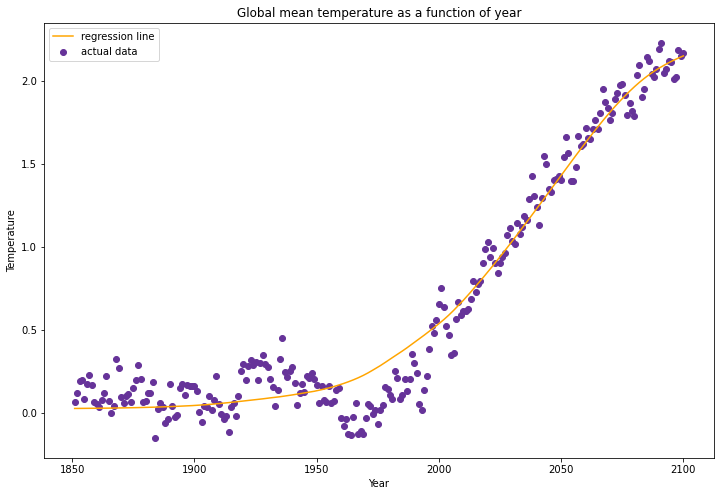

In [15]:
X = np.array(result['year'])#.reshape(-1,1)
# Plotting the year and original temperature as scatter plot
plt.figure(figsize=(12,8))
plt.scatter(X,y, label='actual data', color='rebeccapurple')
# Plotting the regression line using the year and predicted temperature
plt.plot(X,predicted_temperatures, color='orange', label='regression line')
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.title('Global mean temperature as a function of year')
plt.legend()
plt.show()

Where does the prediction do well? Where does it do less well? Visualise the residuals.

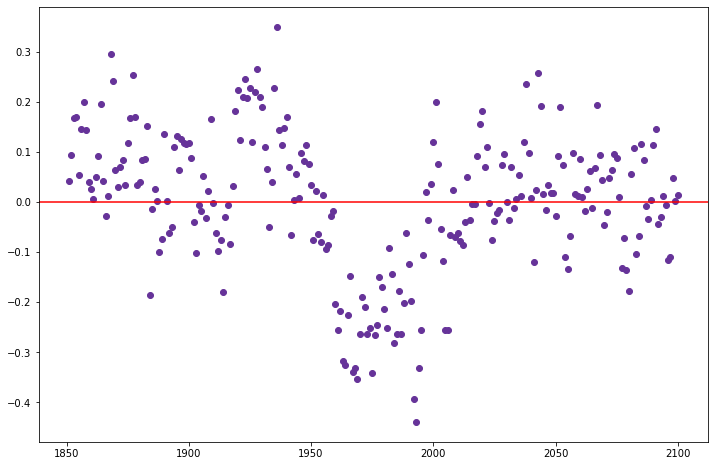

In [16]:
# Residual means the difference between the original value and the predicted values
# In this context, we will get the residual temperature by subtracting the original value with the predicted value
residual = y - predicted_temperatures
# If the residual is equal to zero that means the predicted value is equal to the original value
# We will plot a line  going through y=0 so that we can compare for which year the model performed well and where it didn't perform well
plt.figure(figsize=(12,8))
plt.axhline(y=0, color='r', linestyle='-')
#plotting residual value vs year as a scatter plot
plt.scatter(result['year'], residual,color='rebeccapurple')
plt.show()

 Where does the prediction do well?

Between the period 1850 to 1950 and 2000 to 2100 the model does a good job in keeping the residual values close to zero. i.e. Many predicted values were either exactly similar or very close to the original values. The accuracy of our model turns out to be good during these timeframes.

Where does it do less well?

In contrast during the timeframe 1950 to 2000 none of our prediction were accurate and they were very far away from the actual values. The error in these values makes our model less accurate. This can be confirmed by looking at the graph Global mean temperature as a function of year where the values are away from the regression line showing inconsistency in our model.

## 4. Extend this to a regional temperature model, by region, and by state

While the relationship between global temperature and cumulative CO2 emissions is very linear, the relationship between regional temperature and cumulative CO2 emissions is less so. This is because the regional temperature is affected by other factors, such as the regional distribution of land and ocean, and the regional distribution of CO2 emissions. Nevertheless, let's see how well it can do

In [17]:
country_mask_file = 'country_mask.nc'
# We need to open it with open_dataarray as the country data is stroed in the data variable in the form of a dataarray
country_mask = xr.open_dataarray(country_mask_file,decode_times=True)
country_mask

<xarray.DataArray (lat: 96, lon: 144)>
[13824 values with dtype=<U24]
Coordinates:
  * lat      (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

Average the spatial coordinates into countries so that we end up with a dataset that has dimensionality of the number of countries by the number of time points.

In [21]:
# country_mask.data will give us the country data along the coordinates
countries = country_mask.data

# creating a new dataset with new coordinate i.e. countries
new_ds = temparature_dataset.assign_coords(countries=(("lat", "lon"), countries))   
new_ds

# Grouping the dataset based on the countries coordinates such that it becomes a dimension
countries_ds = new_ds.groupby("countries").mean()
countries_ds

<xarray.Dataset>
Dimensions:    (time: 250, countries: 150)
Coordinates:
  * time       (time) int64 1851 1852 1853 1854 1855 ... 2097 2098 2099 2100
    quantile   float64 ...
  * countries  (countries) object 'Afghanistan' 'Albania' ... 'Zimbabwe'
Data variables:
    tas        (time, countries) float32 0.3524 0.2269 0.1874 ... 3.594 3.674

Plot a bar chart of the warming in each country in 2023. Note, the temperature data is baselined to 1850.

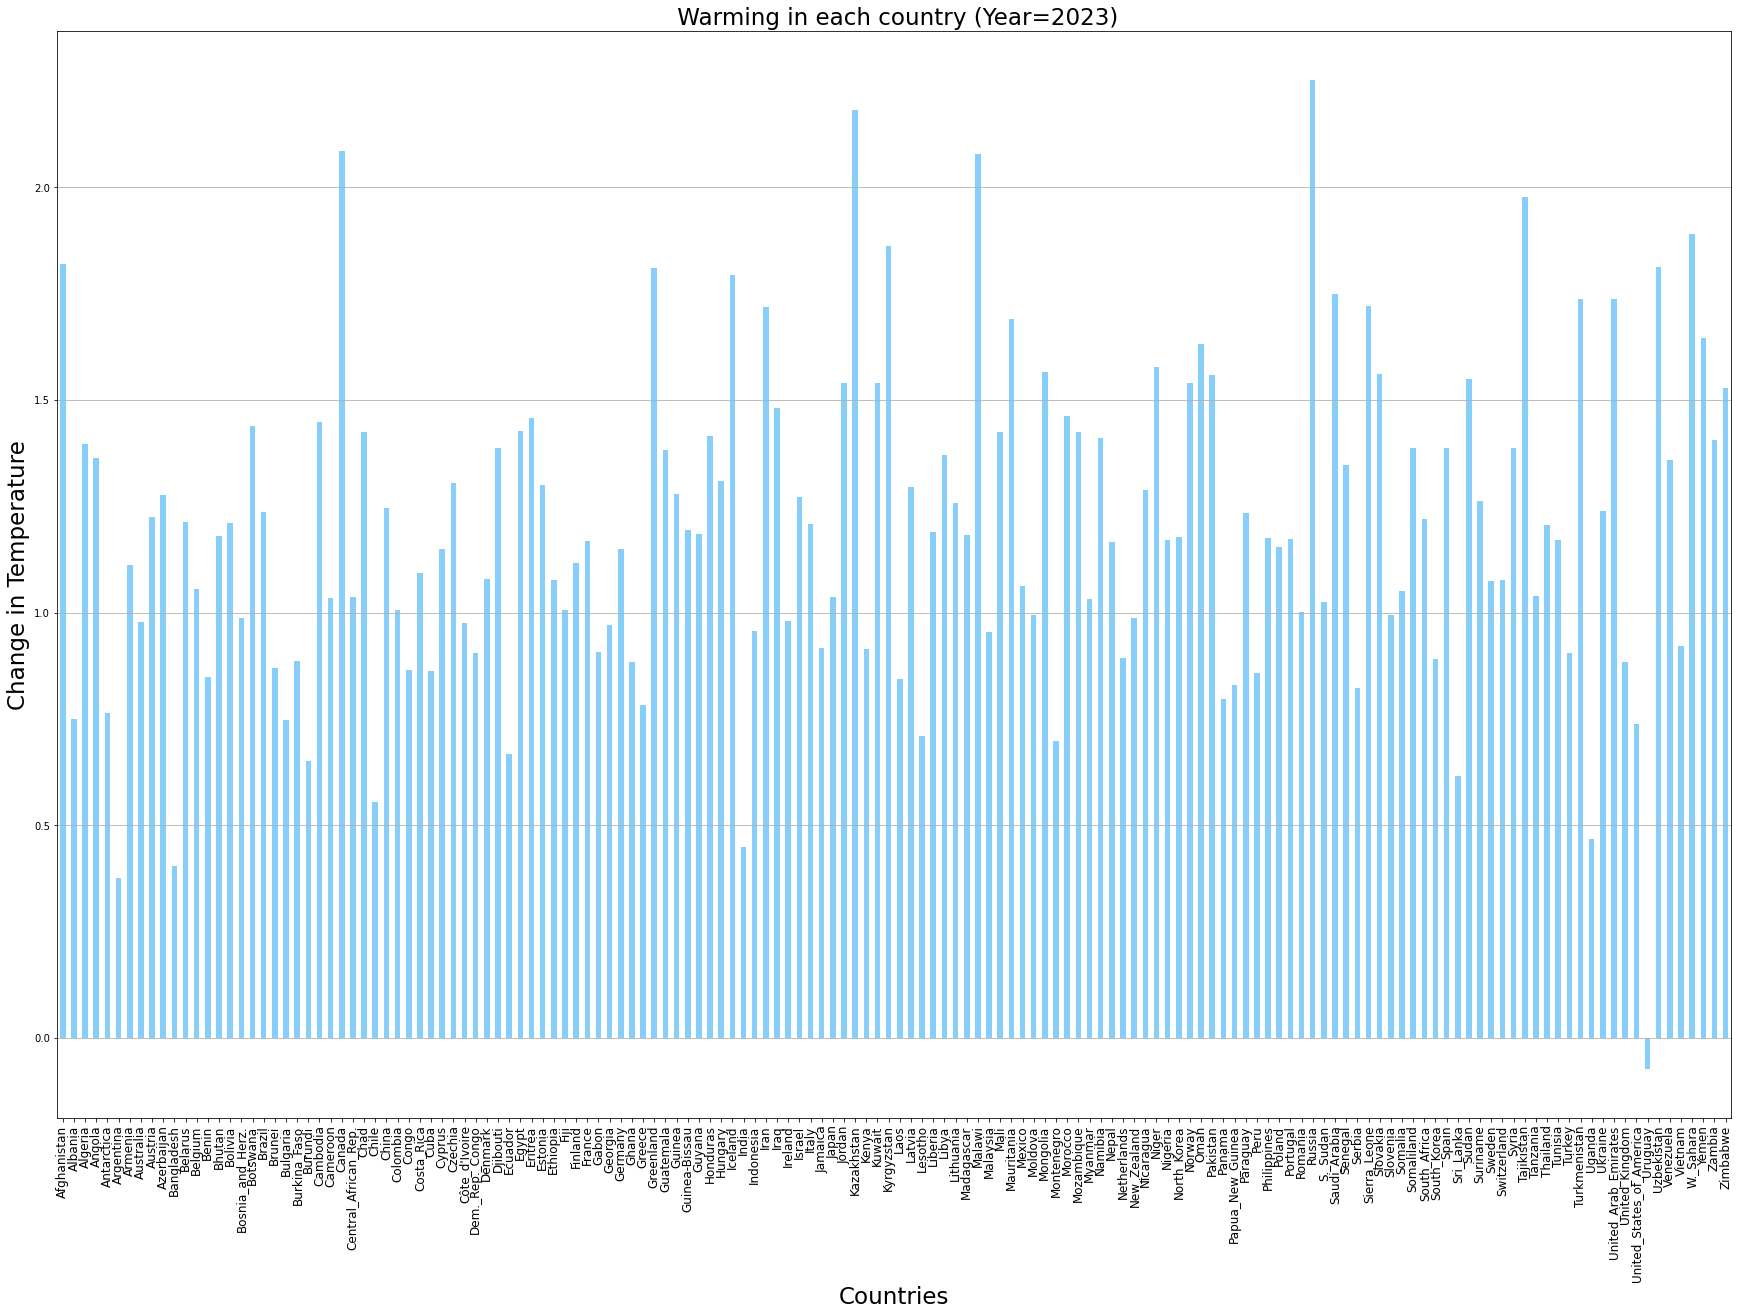

In [22]:
#Setting the figure size
plt.figure(figsize=(30, 20))
# Selecting year as 2023
countries_ds['tas'].sel(time=2023).to_series().plot.bar(color='lightskyblue')
plt.xlabel('Countries', fontsize=23)
plt.ylabel('Change in Temperature', fontsize=23)
plt.title(' Warming in each country (Year=2023)', fontsize=23)
plt.xticks(fontsize=12)
plt.grid(axis='y')
plt.show()

Calculate a linear regression model for each country along with the R^2 value. Plot the R^2 values for each country as a bar chart.

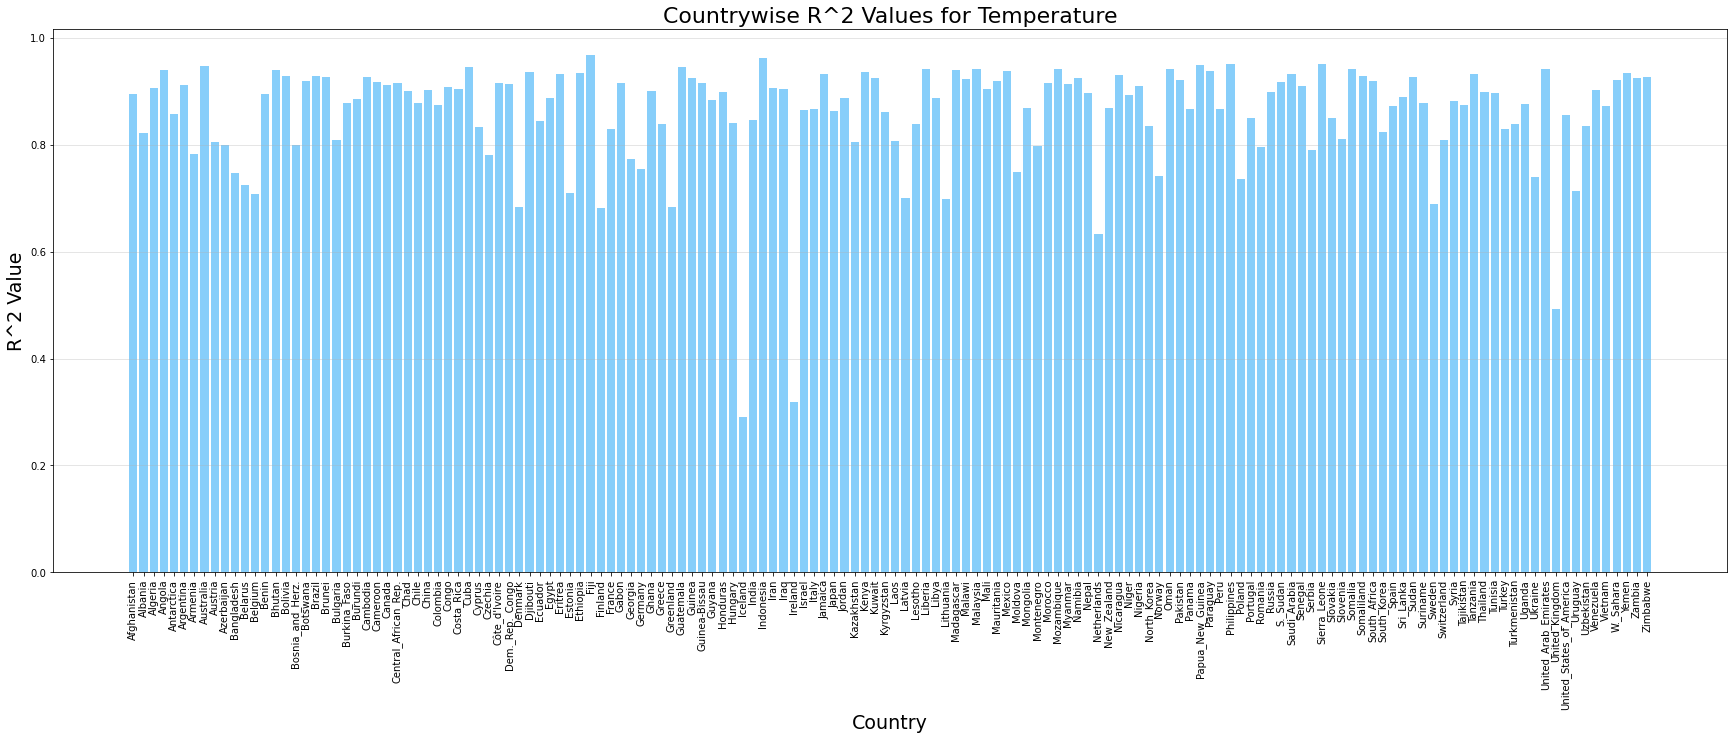

In [23]:
r_square = {}

# Taking each country value from the dataset
for country in countries_ds['tas'].countries.values:
    # Getting the temperature data for the selected country
    temp_timeseries = countries_ds['tas'].sel(countries=country)
    
    # Taking the cumulative CO2 as the input data and converting it to a 2D array
    X = np.array(result['cumulative_CO2']).reshape(-1,1)
    
    # Taking the Temperature as the data to predict
    y = temp_timeseries.values  
    
    # Using linear regression model to fit the data
    model = LinearRegression()
    model.fit(X, y)
    
    # Calculating R^2 value
    r_square[country] = model.score(X, y)
    

# Extracting the countries and the R^2 values from the dictionary
countries = list(r_square.keys())
r_square_values = list(r_square.values())

# Setting figure size ensuring data and labels are visible
plt.figure(figsize=(30, 10)) 

# Creating a bar chart for R^2 value vs country
plt.bar(countries, r_square_values, color='lightskyblue')
plt.title('Countrywise R^2 Values for Temperature', fontsize=22)
plt.xlabel('Country', fontsize=19)
plt.ylabel('R^2 Value', fontsize=19)

# Rotate xticks such that they don't overlap
plt.xticks(np.arange(len(countries)), countries, rotation=90)
plt.grid(axis='y', alpha=0.4)
plt.show()

For which countries does the linear assumption work well, and where does it work less well?

R-square value shows how well the data fit the regression model.

High Rsquared value means that more variability is explained by the model and the model can better explain the observed data.

Low Rsquared value means that less variability is explained by the model and the model isn't able to explain the observed data.
 

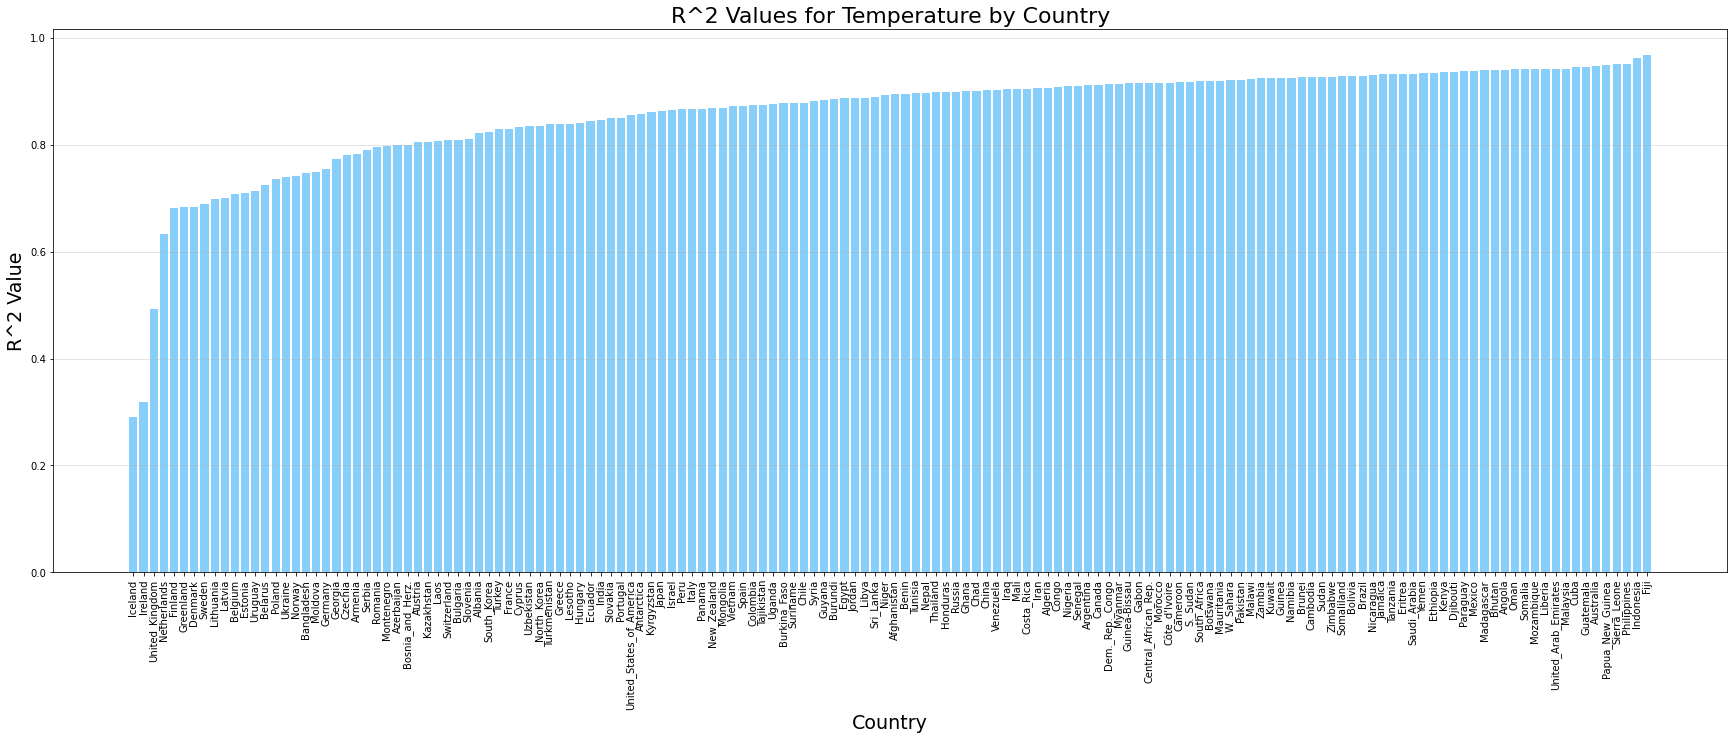

In [24]:
r_square = {k: v for k, v in sorted(r_square.items(), key=lambda item: item[1])}
# Extracting the countries and the R^2 values from the dictionary and converting it into list
countries = list(r_square.keys())
r_square_values = list(r_square.values())

# Setting figure size ensuring data and labels are visible
plt.figure(figsize=(30, 10)) 

# Creating a bar chart for sorted R^2 value vs country
plt.bar(countries, r_square_values, color='lightskyblue')
plt.title('R^2 Values for Temperature by Country', fontsize=22)
plt.xlabel('Country', fontsize=19)
plt.ylabel('R^2 Value', fontsize=19)

# Rotate xticks such that they don't overlap
plt.xticks(np.arange(len(countries)), countries, rotation=90)
plt.grid(axis='y', alpha=0.4)
plt.show()

From the above graph we can see that countries like Iceland, Ireland, United_Kingdom, Netherlands have low R^2 values while countries like Fiji, Indonesia, Phillipines, Sierra_Leone, Papua_New_Guinea have a very high R^2 values.

The model fits well and cumulative_CO2 can explain the temperature change in this high r-square value countries accurately.

In case of the low r square value countries the temperature change must be influences by some other factors too and thus linear regression using CO2 emission is not able to explain the temperature change in these countries.

Another trend that can be noticed based on geographical knowledge is that all low r-square values countries are European countires while a majority of high R square value countries belong to the Oceania region.

So it can be said that the model can better explain the observed data in the Oceania region while it can't do the same for European region.

## 5. Plot the regression coefficients for each country


Which five countries are most sensitive to CO2 emissions and hence warming the fastest?

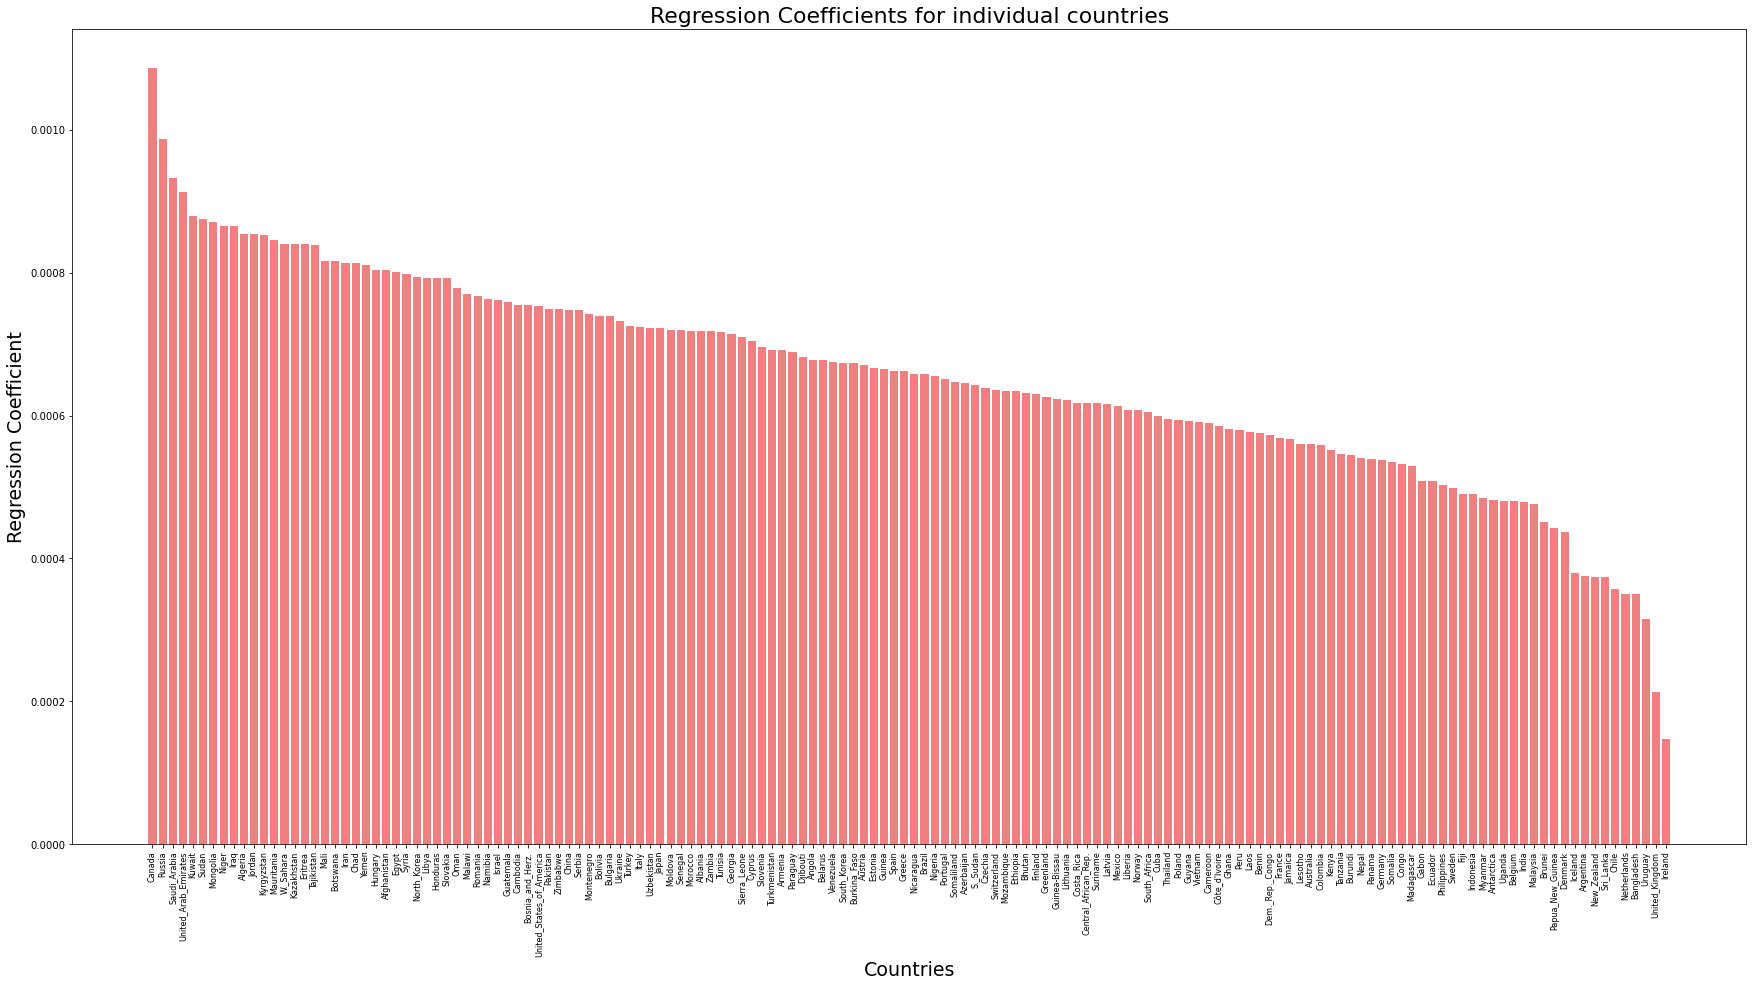

Top five countries most sensitive to CO2 emissions:  ['Canada', 'Russia', 'Saudi_Arabia', 'United_Arab_Emirates', 'Kuwait']


In [25]:
coefficients = {}

# Taking each country value from the dataset
for country in countries_ds['tas'].countries.values:
    
    # Taking the cumulative CO2 as the input data and converting it to a 2D array
    X = np.array(result['cumulative_CO2']).reshape(-1,1)
    # Taking the Temperature as the data to predict
    y = countries_ds['tas'].sel(countries=country).values

    # Using linear regression model to fit the data
    model = LinearRegression()
    model.fit(X, y)

    # Calculating countrywise regression coefficients
    coefficients[country] = model.coef_[0]

# Getting the list of countries from the dictionary
countries = list(coefficients.keys())
# Getting the list of coefficients from the dictionary
coeffs = list(coefficients.values())

# Sorting the countries 
sorted_countries = sorted(countries, key=lambda x: abs(coefficients[x]), reverse=True)

# Sorting the coefficients based on the sorted countries
sorted_coeffs = [coefficients[country] for country in sorted_countries]

# Plotting the coefficients
plt.figure(figsize=(30, 15))
plt.bar(sorted_countries, sorted_coeffs, color='lightcoral')
plt.xlabel('Countries', fontsize=19)
plt.ylabel('Regression Coefficient', fontsize=19)
plt.title('Regression Coefficients for individual countries', fontsize=22)
plt.xticks(rotation=90, fontsize=8)
plt.show()

# Identify the five countries with the largest absolute coefficients
print("Top five countries most sensitive to CO2 emissions: ",sorted_countries[:5])

Let us compare the temperature variation in the country with the highest average temperature change over time and the country with the lowest average temperature change over time

In [26]:
from sklearn.ensemble import RandomForestRegressor
import xarray as xr

# Calculating the average temperature along the 'time' dimension
average_temperature = countries_ds['tas'].mean(dim='time')

# Find the country with the maximum average temperature
max_avg_country = average_temperature.argmax(dim='countries')

# Find the country with the minimum average temperature
min_avg_country = average_temperature.argmin(dim='countries')

# Get the actual country names using the coordinates
max_avg_country_name = countries_ds['countries'].values[max_avg_country]
min_avg_country_name = countries_ds['countries'].values[min_avg_country]

# Get the maximum and minimum average temperatures
max_avg_temperature = average_temperature.sel(countries=max_avg_country_name).item()
min_avg_temperature = average_temperature.sel(countries=min_avg_country_name).item()

# Print the results
print(f"Country with Maximum Average Temperature Change: {max_avg_country_name} ({max_avg_temperature} °C)")
print(f"Country with Minimum Average Temperature Change: {min_avg_country_name} ({min_avg_temperature} °C)")

Country with Maximum Average Temperature Change: Canada (1.499695897102356 °C)
Country with Minimum Average Temperature Change: Ireland (0.19904541969299316 °C)


We can see that Canada has the maximum average temperature change over the years and Ireland isn't much influenced by the CO2 emissions and the temperature has increased very slowly.

Let's verify the same using plot and instaed of linear regression we will measure the accuracy using the random forest model.

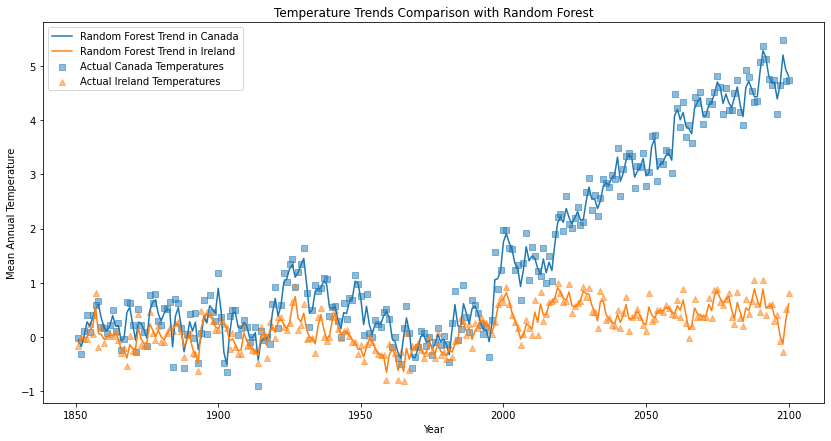

In [27]:
max_temp_country1 = max_avg_country_name
min_temp_country2 = min_avg_country_name

r_square = {}

# Calculate annual mean temperatures for each selected country
country1_annual_mean_temp = countries_ds['tas'].sel(countries=max_temp_country1).groupby('time').mean(...)
country2_annual_mean_temp = countries_ds['tas'].sel(countries=min_temp_country2).groupby('time').mean(...)

# Prepare the data for regression models
years = np.array(country1_annual_mean_temp.time)
X = years.reshape(-1, 1)

# Fit a Random Forest Regressor to analyze temperature trends
random_forest_model_country1 = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model_country1.fit(X, country1_annual_mean_temp)
r_square[max_temp_country1] = random_forest_model_country1.score(X, country1_annual_mean_temp)

random_forest_model_country2 = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model_country2.fit(X, country2_annual_mean_temp)
r_square[min_temp_country2] = random_forest_model_country2.score(X, country2_annual_mean_temp)

# Predict temperatures using the trained models
predicted_temps_country1 = random_forest_model_country1.predict(X)
predicted_temps_country2 = random_forest_model_country2.predict(X)

# Plot the trends and actual temperature data for visual comparison
plt.figure(figsize=(14, 7))
plt.plot(years, predicted_temps_country1, label=f'Random Forest Trend in {max_temp_country1}')
plt.plot(years, predicted_temps_country2, label=f'Random Forest Trend in {min_temp_country2}')
plt.scatter(years, country1_annual_mean_temp, label=f'Actual {max_temp_country1} Temperatures', alpha=0.5, marker='s')
plt.scatter(years, country2_annual_mean_temp, label=f'Actual {min_temp_country2} Temperatures', alpha=0.5, marker='^')
plt.xlabel('Year')
plt.ylabel('Mean Annual Temperature')
plt.title('Temperature Trends Comparison with Random Forest')
plt.legend()
plt.show()

From the above graph we can see that over the years the temperature in Canada has increased very rapidly in comparison to Ireland and in the future the temperature will increase even more rapidly.

In case of Ireland the temperature has remained fairly the same over the years and will follow a straight trajectory in the future years to come given that no other factor other than the CO2 emisssion affect it.

The random forest model is more accuarate in comparison to the linear regession model as it is able to handle the outliers more efficiently and predicts the temperature more accurately.

In [28]:
r_square
print(f"R_Square value for {max_temp_country1} is: ", r_square[max_temp_country1])
print(f"R_Square value for {min_temp_country2} is: ", r_square[min_temp_country2])

R_Square value for Canada is:  0.992232226592747
R_Square value for Ireland is:  0.9260758233604267


We can see from the above data that the model performs surprisingly very well on the training data and we can conclude that the random forest classifier has been overfitted and might not perform well on new data.

Both the countries follow similar trend till the year 1990 and then show sharp distinction thereafter. In case of Canada the temperature change will rise from 0 to 4.5 till the year 2100 while Canada had average temperature change of 0 and till 2100 the temperature will change only by 0.5 degrees.

In [29]:
std_dev_country1 = country1_annual_mean_temp.std(dim='time')
print(f"Standard deviation for {max_temp_country1} is: ", std_dev_country1.data)
std_dev_country2 = country2_annual_mean_temp.std(dim='time')
print(f"Standard deviation for {min_temp_country2} is: ", std_dev_country2.data)

Standard deviation for Canada is:  1.6591637134552002
Standard deviation for Ireland is:  0.37983444333076477


From the above calculation we can see that Canada has a higher standard deviation and Ireland has a lower standard deviation in comparison to Canada.

Lower value of standard deviation means Ireland has a more stable temperature over time in comparison to Canada 

## 7. Make a command line interface to a prediction script 

The inputs should include the name of a country (or global mean) and CO2 concentration(s). It should return the predicted temperature change relative to 1850. We can use the `argparse` package to do this. See [here](https://docs.python.org/3/howto/argparse.html) for documentation.

Also provide the option to save the predictions to a CSV file.

This script should use the regression coefficients learned in the previous step so it doesn't have to use the full model output each time. We can store them in a numpy file, a pandas CSV file, or even JSON. 

In [30]:
#creating a pandas dataframe from the sorted countries and respective sorted coeffiecients to save as csv for the .py for CLI
sorted_list = list(zip(sorted_countries, sorted_coeffs))

sorted_df = pd.DataFrame(sorted_list, columns = ['countries', 'coeff'])
sorted_df.to_csv('Regression_coefficients.csv')

In [31]:
!python final.py --co2_concentration 50 --country Mali --save_csv

Predicted temperature change for Mali with Co2 concentration 50.0: 0.040841436008295 in °C
output saved : final_prediction_results.csv


# Below is the code for final.py file

In [ ]:
import argparse
import pandas as pd

def temp_prediction(co2_concentration, country, coefficients, save_csv=False):
    if country not in coefficients['countries'].values:
        print(f"Country '{country}' not found in the csv file.")
        return
    coefficient = coefficients.loc[coefficients['countries'] == country, 'coeff'].iloc[0]
    temp_change = co2_concentration * coefficient
    print(f'Predicted temperature change for {country} with Co2 concentration {co2_concentration}: {temp_change} in °C')

    if save_csv:
        result_df = pd.DataFrame({
            'Country': [country],
            'CO2 Concentration': [co2_concentration],
            'Temperature Change': [temp_change]
        })
        result_df.to_csv('final_prediction_results.csv', index=False)
        print('output saved : final_prediction_results.csv')
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--co2_concentration', type=float)
    parser.add_argument('--country', type=str)
    parser.add_argument('--save_csv', action='store_true')

    args = parser.parse_args()
    
    coefficients = pd.read_csv('Regression_coefficients.csv')
    temp_prediction(args.co2_concentration, args.country, coefficients, args.save_csv)